# Numerical Methods
## Lecture 6: Monte Carlo simulations
by: [Tomasz Romańczukiewicz](mailto:tomasz.romanczukiewicz@uj.edu.pl)

*********************************************************

### Outline
- Random number generators
- Monte Carlo integration
- Stochastic processes
- Stochastic differential equations (SDE)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['axes.grid'] = True
#plt.rcParams.keys()

## Monte Carlo simulations:
- Method of calculations - usually slow convergence $N^{-1/2}$ but OK for multidimensional problems
    - integration
    - minimization (anealing, differential evolution etc) 
    - quantum calculation (path integrals)
- Simulations of real life
    - brownian motion,
    - finance  
    - epidemiology (Covid-19)
    

### Hello world
--------
Task: find an area of a quarter of a circle $r = 1$, and $x>0, y>0$.<br>

Analytically:

$$\int_0^1 \sqrt{1-x^2}\,dx=\frac{\pi}{4}$$

In [2]:
from scipy.integrate import *
result = quad(lambda x: np.sqrt(1-x**2), 0, 1, full_output=1) 
print("Area  : ", result[0])
print("error :", result[0]-np.pi/4)
print("number of evaluations: ", result[2]['neval'])
#quad_explain()

Area  :  0.7853981633974481
error : -2.220446049250313e-16
number of evaluations:  231


The error for trapezoidal rule scales as $E=\mathcal{O}(N^{-2(4,6)})$ where $N$ is a number of calculation.<br>
The problem arises for multidimensional integrals: 
* Errors accumulate: adding $N$ values with error  $\mathcal{O}(N^{-2})$ can result in error $\mathcal{O}(N^{-1})$. There are ways to make it work but
* Even worse: the number of calculations grow exponentially with dimensionality $N_\textrm{comp}=N^D$ (curse of dimensionality)

Monte Carlo approach: 
1. randomly choose a point inside a square $0<x<1$, $0<y<1$
1. check if the points is inside the circle  $x^2+y^2<1$ (don't calculate the square root)
1. repeat calculating the number of points inside the circle 
1.  the area is approximately equal to the ratio of number of points inside the circle to total number of points

<i>If you like to gamble, I tell you I'm your man<br>
You win some, lose some, all the same to me</i>

In [18]:
import numpy as np
Nsamples = 1000_000
x = np.random.random([2, Nsamples])
r2 = np.sum(x*x, axis=0)
# my_result = len(r2[r2<=1])/Nsamples  <--- this is very slow
my_result = np.sum(r2<=1)/Nsamples
print("My result:",  my_result)
print("My error :",  my_result-np.pi/4)

My result: 0.785696
My error : 0.000297836602551671


### Exercise:
 - plot error as a function of Nsamples
 - optimize using numpy vectorization (choose all numbers at once etc.)
 - calculate the volume of a unit ball in 10 (or more) dimensions (how many calculations quad would use performing integration in all dimensions).

### Pseudo-random number generators
- Computer (not quantum) is a deterministic machine, giving predictable results<br>
- Random numbers are unpredictable from definition<br>
- There are however deterministic systems which behave in quite unpredictable way (chaotic systems)<br>
- But there is usually a large correlation  $y_{n+1}=F(y_n, y_{n-1},\ldots, t), y_n\in \mathbb{R}^N$
- Sometimes hidden variables are used

* Good algorithms are very difficult to find
* How to test? is a sequence 1, 2, 3, 4, 5, 6, 7, 8 random?
* Histograms (bins) + $\chi^2$ test
* Correlations $x_{n}=F(x_{n-1}, x_{n-2},\ldots)$

- Lehmer random number generator ${\displaystyle X_{n+1}=a\cdot X_{n}{\bmod{m}}}$ (use with caution)
    - RADU $a=65539$ $m=2^{31}$, period: $2^{29}$ (famously bad)
    - Park and Miller’s “minimal standard” MINSTD  $a = 16807$ and $m = 2^{31} - 1 = 2147483647$.
- Linear congruential generator (LCG) ${\displaystyle X_{n+1}=\left(aX_{n}+c\right){\bmod {m}}}$
- L’Ecuyer's combined multiple recursive generator by  $z_n = (x_n - y_n) \mod m_1$
 where 
 
 $$\begin{aligned}x_n & = (a_1 x_{n-1} + a_2 x_{n-2} + a_3 x_{n-3}) \mod m_1 \\y_n & = (b_1 y_{n-1} + b_2 y_{n-2} + b_3 y_{n-3}) \mod m_2\end{aligned}$$

- Bit generators (maximally equidistributed combined Tausworthe generator)$x_n = (s^1_n \oplus s^2_n \oplus s^3_n)$ where $\oplus$ denotes binary XOR

$$\begin{aligned}
s^1_{n+1} &= (((s^1_n \& 4294967294)\ll 12) \oplus (((s^1_n\ll 13) \oplus s^1_n)\gg 19)) \\s^2_{n+1} &= (((s^2_n \& 4294967288)\ll 4) \oplus (((s^2_n\ll 2) \oplus s^2_n)\gg 25)) \\s^3_{n+1} &= (((s^3_n \& 4294967280)\ll 17) \oplus (((s^3_n\ll 3) \oplus s^3_n)\gg 11))
\end{aligned}$$

- lagged Fibbonacci $S_n \equiv S_{n-j} \oplus S_{n-k}  \pmod{m},   0 < j < k$
- kernel-built generator /dev/random

In [4]:
def show_generators():
    N = 10000
    x1 = np.empty(N+1)
    x2 = np.empty(N+1)
    
    a, m1, x1[0] = 65539, 1<<25, 126536  # bad LCG
    for n in range(N):
        x1[n+1] = (a*x1[n])%m1

    m2, x2[0] = 1<<31, 126536    # OK LCG
    for n in range(N):
        x2[n+1] = (a*x2[n])%m2
    x = np.random.random(N+1)    # standard generator    
    plt.figure(figsize=(10, 3))    
    plt.subplot(1, 3, 1);    plt.xlabel('$x_{n}$');   plt.ylabel('$x_{n+1}$')
    plt.title('Bad LCG')
    plt.plot(x1[0:-1]/m1, x1[1:]/m1, 'r.', markersize=0.5)    
    plt.subplot(1, 3, 2); plt.xlabel('$x_{n}$')
    plt.title('OK LCG')
    plt.plot(x2[0:-1]/m2, x2[1:]/m2, 'g.', markersize=0.5)
    plt.subplot(1, 3, 3); plt.xlabel('$x_{n}$')
    plt.title('Default generator')
    plt.plot(x[0:-1], x[1:], 'b.', markersize=0.5)
    plt.show()

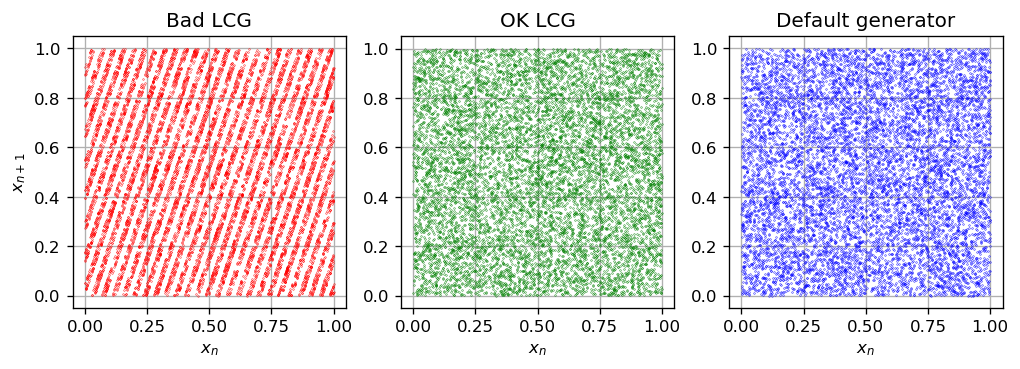

In [5]:
show_generators()

### Nonuniform distributions
#### Transformation method
Let $x$ be a random number with uniform distribution $[0, 1)$.<br>
We want to have a random number $y$ with a distribution density given by a function $p(y)$<br>
But probabilty is an integral which transforms in the following way
$$P=\int_{x_1}^{x_2}dx = \int_{y_1}^{y_2}\frac{dx}{dy}dy = \int_{y_1}^{y_2}p(y)dy$$
That means that

$$p(y)=\frac{dx}{dy}$$

$$y(x)=F^{-1}(x)\,, \;\;\textrm{where}\;\;F(y)=\int_{0}^yp(y')\,dy'$$

Seems difficult, doesn't it?

#### Example: generate exponential distribution

$$p(y)=e^{-y}$$

$$F(y)=\int_{0}^yp(y')\,dy'=1-e^{-y}=x(y)$$

so the transformation is 

$$y(x) = -\log(1-x)$$

In [6]:
def distribution_example(N=5000):
    x = np.random.random(N)
    y = -np.log(1-x)
    plt.hist(y, bins=np.linspace(0, 6, 50), density='True', label='generated dist.')
    z = np.linspace(0, 6, 1000)
    plt.plot(z, np.exp(-z), 'black', label='desired dist.')
    plt.xlabel('$y$', fontsize=16)
    plt.ylabel('$p(y)$', fontsize=16)
    plt.legend()
    plt.show()

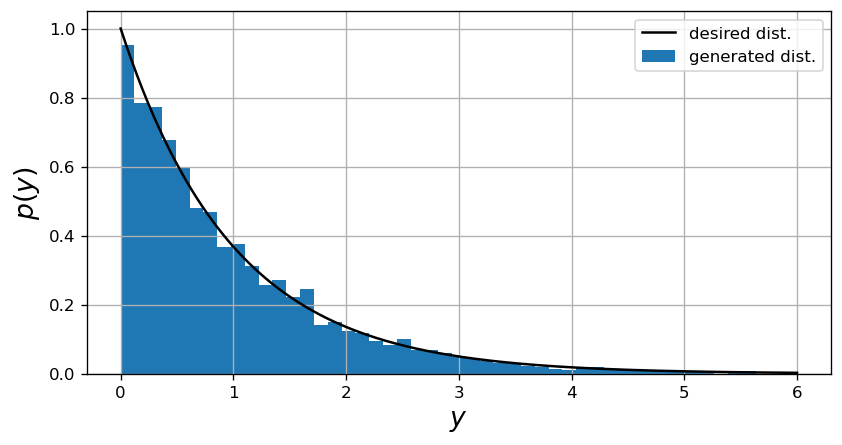

In [7]:
distribution_example()

### Normal distribution Box-Muller method

$$p(y)dy=\frac{1}{\sqrt{2\pi}}e^{-y^2/2}\,dy$$

We generate __two__ numbers $x_1, x_2 \in(0,1)^2$and make the transform

$$y_1=\sqrt{-2\log x_1}\cos(2\pi x_2)$$

$$y_2=\sqrt{-2\log x_1}\sin(2\pi x_2)$$

then

$$p(y_1,y_2)dy_1dy_2=p(x_1, x_2)dx_1dx_2$$

But 

$$dx_1dx_2=\left|\frac{\partial(x_1, x_2)}{\partial(y_1, y_2)}\right|dy_1dy_2$$

The Jacobian is

$$Jac = -\left(\frac{1}{\sqrt{2\pi}}e^{-y_1^2/2}\right)\left(\frac{1}{\sqrt{2\pi}}e^{-y_2^2/2}\right)$$

Therefore $y_1$ ad $y_2$ are independent and have normal distributions. 

In [8]:
def rejection_plot():
    x = np.linspace(0,1, 1000)
    y = x**4*np.sin(np.pi*x) 
    #plt.figure(figsize=(5, 3))     
    fig, ax = plt.subplots()
    ax.fill_between(x, 0, y, facecolor='green', alpha=0.2)
    ax.plot(x, y, 'black', label='$p(y)$')
    plt.ylabel('$x$', fontsize=16)
    plt.xlabel('$y$', fontsize=16)
    X = [0.1, 0.3, 0.6, 0.8]
    Y = [0.2, 0.12, 0.1, 0.15]
    ax.plot(X[0:2], Y[0:2], 'ro', fillstyle='none', label='rejected')
    ax.plot(X[2:], Y[2:], 'bo', label='accepted')
    plt.legend()
    plt.show()

### Rejection method
* generate a pair $x, y$ from uniform distribution. 
* reject if $x>p(y)$ 
* accept if $x<p(y)$ 

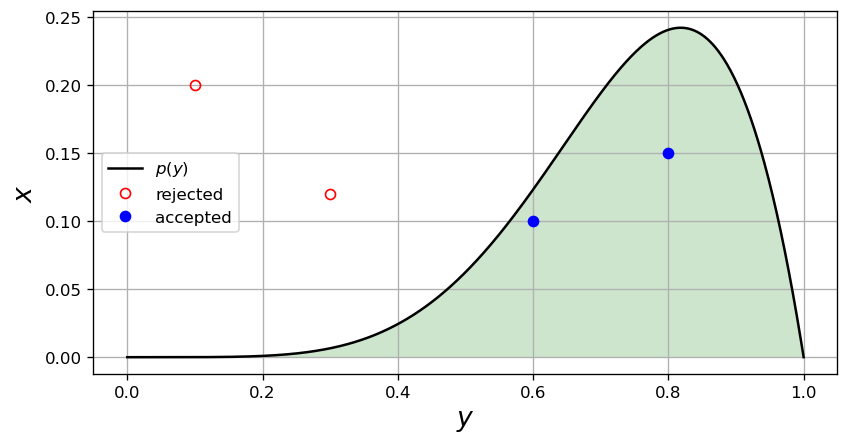

In [9]:
rejection_plot()

Some distributions provided by <tt>numpy.random</tt>
- beta
- binomial
- chi-square 
- exponential
- logistic
- multinomial
- hypergeometric
- normal (Gaussian) 
- uniform

Often used also <tt>scipy.stats</tt> or <tt>random.random</tt>

## Brownian motion
Let us denote a probability that a particle would move from $x$ to $x-y$ in time $\tau$ by $\varphi(y)dy$
Then the whole distribution $\rho(x, t)$ is governed by a convolution

$$\rho(x, t+\tau) = \rho(x, t) + \int_{-\infty}^\infty\rho(x-y,t)\,\varphi(y)dy$$

for sufficiently short times $\tau\ll1$ and if $\varphi(-y)=\varphi(y)$:

$$\rho(x, t+\tau) = \rho(x, t) +  \frac{\partial\rho}{\partial t}\tau = \rho(x, t) + \frac{\partial^2\rho}{\partial x^2}\int_{-\infty}^\infty\frac{y^2\varphi(y)}{2}dy + \text{higher moments}$$



We end up with diffusion equation:

$$\frac{\partial\rho}{\partial t} = D \frac{\partial^2\rho}{\partial x^2}$$

where

$$D = \int_{-\infty}^\infty\frac{y^2\varphi(y)}{2 \tau}dy=\text{const}$$

if higgher moments are used:

$$\frac{\partial\rho}{\partial t} = D_2 \frac{\partial^2\rho}{\partial x^2}+D_4 \frac{\partial^4\rho}{\partial x^4}+\cdots$$

Fundamental solution of the diffusion equation($D_2=D, D_{n>2}=0$):<br>
Assuming $\rho(x, 0) = \delta(x)$

$$\rho(x,t)={\frac {1}{\sqrt {4\pi Dt}}}\exp \left(-{\frac {x^{2}}{4Dt}}\right)$$

or in more general

$$\rho(x,t)={\frac {1}{\sqrt {4\pi Dt}}}\int_{-\infty}^{\infty}\exp \left(-{\frac {(x-s)^{2}}{4Dt}}\right)\rho(s,0)\,ds.$$

Note: diffusion can only evolve forward $t>0$

### Central limit theorem
Let ${X_1, X_2,\ldots,X_n}$ be a random sample of independent and identically distributed random variables shuch that $\operatorname {E} [X_i]=\mu$ and $\operatorname {var}[X_i]=\sigma^2$ than the sequence 

$$S_n=\frac{X_1+X_2+\cdots+X_n}{n}$$

would tend to a normal distribution with $\operatorname {E} [S_i]=\mu$ and $\displaystyle \operatorname {var}[S_i]=\frac{\sigma^2}{n}$


If $x, y$ have a distribution $\rho_1(x)$ than the distrubution of sum $s=x+y$ would be a convolution of identical distributions.

$$\rho_2(s) = \int\rho(s-y)\rho(y)\,dy=(\rho_1\circ\rho_1)(s)$$

For simplicity let us assume that $\operatorname {E} [x]=\operatorname {E} [y]=0$. We can construct a series of $\rho_{n+1}=\rho_n\circ\rho_n$

In [10]:
def show_accumulative_distro(x, ρ):
    N = x.size
    ρ /= np.sum(ρ)*(x[-1]-x[0])/(ρ.size-1)
    plt.figure(figsize=(12, 8), dpi=100)
    plt.subplot(3, 3, 1); plt.ylabel(r'$\rho_n(x)$',  usetex=True, fontsize=16)
    plt.plot(x, ρ, label='initial')
    plt.legend()
    for n in range (8):       
        ρ = np.convolve(ρ,ρ) * (x[-1]-x[0]) / (ρ.size-1) # normalization 
        ρ = ρ[0::2] 
        x = np.linspace(2*x[0], 2*x[-1], ρ.size)
        plt.subplot(3, 3, n+2)          
        if n%3==2: plt.ylabel(r'$\rho_n(x)$',  usetex=True, fontsize=16)
        if n>=5: plt.xlabel('$x$',  usetex=True, fontsize=16)
        plt.plot(x, ρ, 'C'+str(n+1), label=f'n={n+1}')
        plt.legend()
    plt.show()

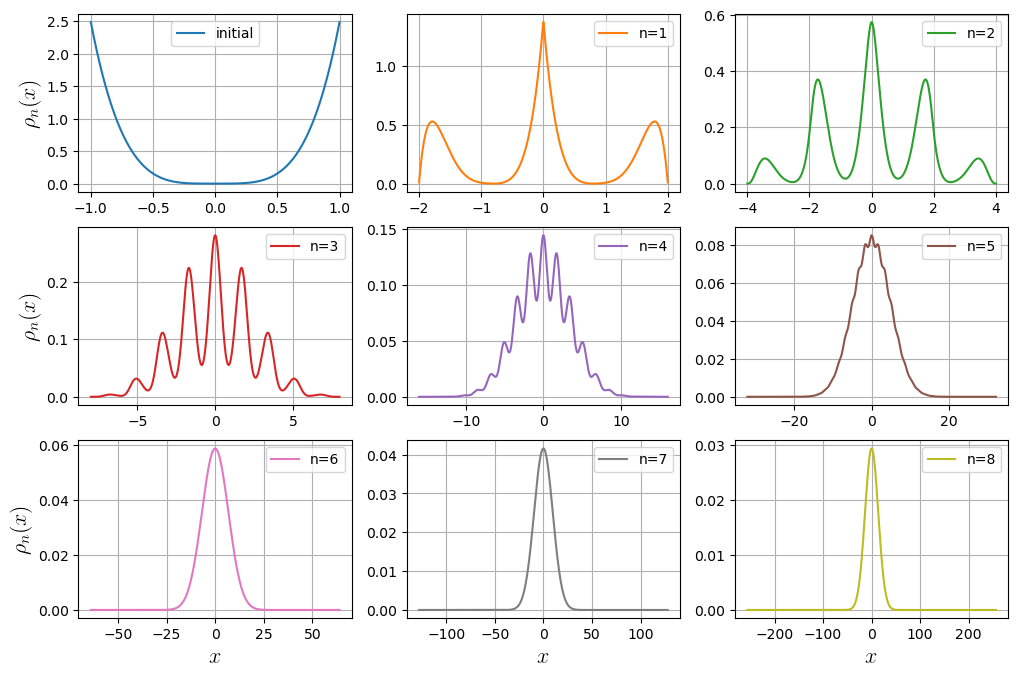

In [11]:
x = np.linspace(-1, 1, 1000)
#ρ = np.float64(np.abs(x-0.8)<0.1) + np.float64(np.abs(x+0.8)<0.1) 
ρ = x**4
show_accumulative_distro(x, ρ)    

In [12]:
from scipy.stats import norm
def brownian_motion(σ=2, T=10, N=1000):
    t = np.linspace(0, T, N)
    dt = t[1]-t[0]

    r = norm.rvs(size=t.shape, scale=σ**2*dt)
    x = np.cumsum(r)  # used cumulative sum instead of loop
    plt.plot(t, x)
    plt.xlabel('$t$',  usetex=True, fontsize=16)
    plt.ylabel('$x$',  usetex=True, fontsize=16)
    plt.show()

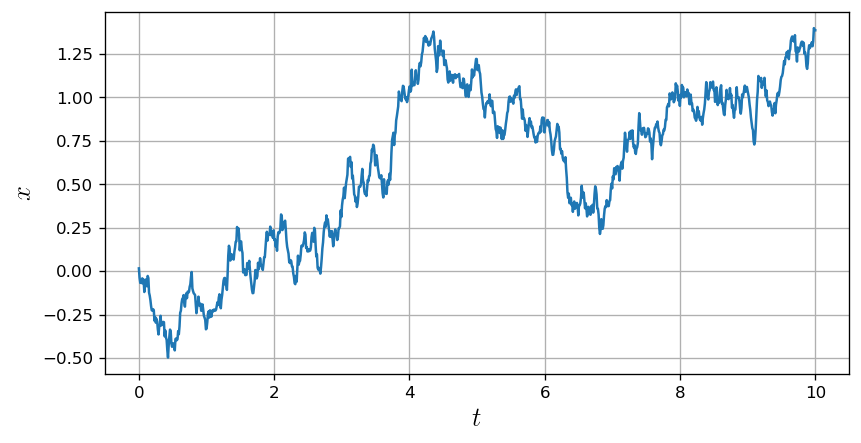

In [13]:
brownian_motion()

In [14]:
def brownian(x0, n, dt, delta, out=None):
    """    Example from https://scipy-cookbook.readthedocs.io/items/BrownianMotion.html     """ 
    x0 = np.asarray(x0)

    r = norm.rvs(size=x0.shape + (n,), scale=delta*np.sqrt(dt))
    if out is None:
        out = np.empty(r.shape)
    np.cumsum(r, axis=-1, out=out)
    out += np.expand_dims(x0, axis=-1)

    return out

In [15]:
def example_multi_brownian(σ=2, T=10, N=1000, m=20, plotting=False):
    dt = T/N
    x = np.empty((m,N+1))
    x[:, 0] = 0

    brownian(x[:,0], N, dt, σ, out=x[:,1:])
    if plotting==True:
        t = np.linspace(0.0, N*dt, N+1)
        for k in range(m):
            plt.plot(t, x[k])
        plt.xlabel('$t$',  usetex=True, fontsize=16)
        plt.ylabel('$x$',  usetex=True, fontsize=16)
        plt.show()
    return x

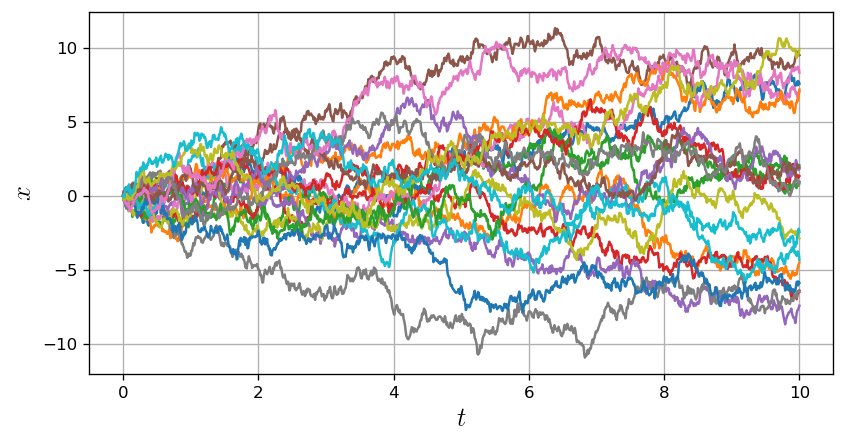

In [16]:
 X = example_multi_brownian(σ=2, T=10, N=1000, m=20, plotting=True)

In [17]:
def compare_diff_brownian(σ=2, T=1, N=101, m=1000):
    X = example_multi_brownian(σ, T, N, m, plotting=False)
    plt.figure(figsize=(12, 4), dpi=100)
    for n in range(6):
        plt.subplot(2,3,n+1)
        x = np.linspace(-5,5,1000)
        k = 15*(n+1)
        t = k*T/(N-1)
        plt.hist(X[:, k], bins=np.linspace(-5, 5, 50), density='True', color='C'+str(2*n))
        Dt = 2*t
        g = np.exp(-x**2/(4*Dt))/np.sqrt(4*np.pi*Dt)
        plt.plot(x, g, 'black', label=f"t={t}")
        plt.legend()
        if n>=3: plt.xlabel('$x$',  usetex=True, fontsize=16)
        if n%3==0: plt.ylabel(r'$\rho(x)$',  usetex=True, fontsize=16)

    plt.show()

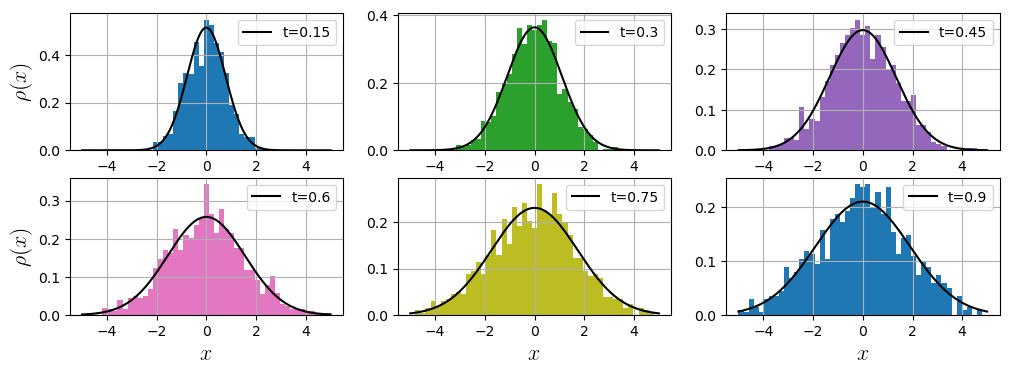

In [18]:
compare_diff_brownian()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['axes.grid'] = True
#plt.rcParams.keys()

In [13]:
def quarter_disk(N = 100):
    x = np.random.random([N,2])
    r2 = np.sum(x*x, axis=1)
    return len(r2[r2<=1])/N

M = 1_000
n = np.arange(M)
res = np.zeros_like(n, dtype=float)
for m in n:
    res[m] = quarter_disk(1000)

def show_MC_convergence():    
    plt.rcParams['text.usetex']=True
    plt.plot(n, res, 'o', ms = 2)
    plt.plot(n, np.cumsum(res)/(n+1), lw =4)
    plt.plot(n, 0*n+np.pi/4, '--', color='black')
    plt.title('MC converngence')
    plt.xlabel('$n \\times 1000$')
    plt.ylabel('result')
    plt.xlim(0, 300)

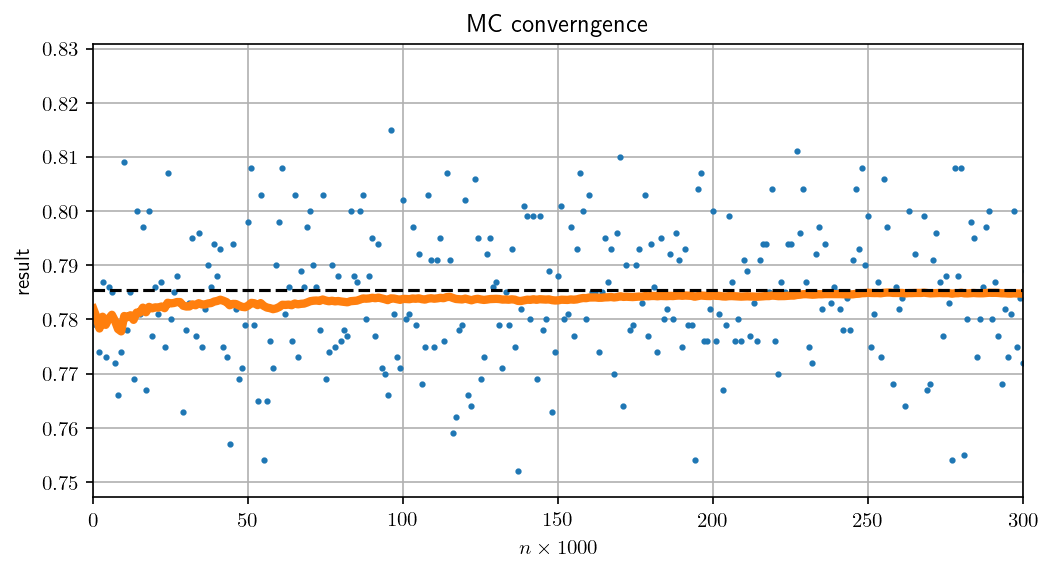

In [9]:
show_MC_convergence()

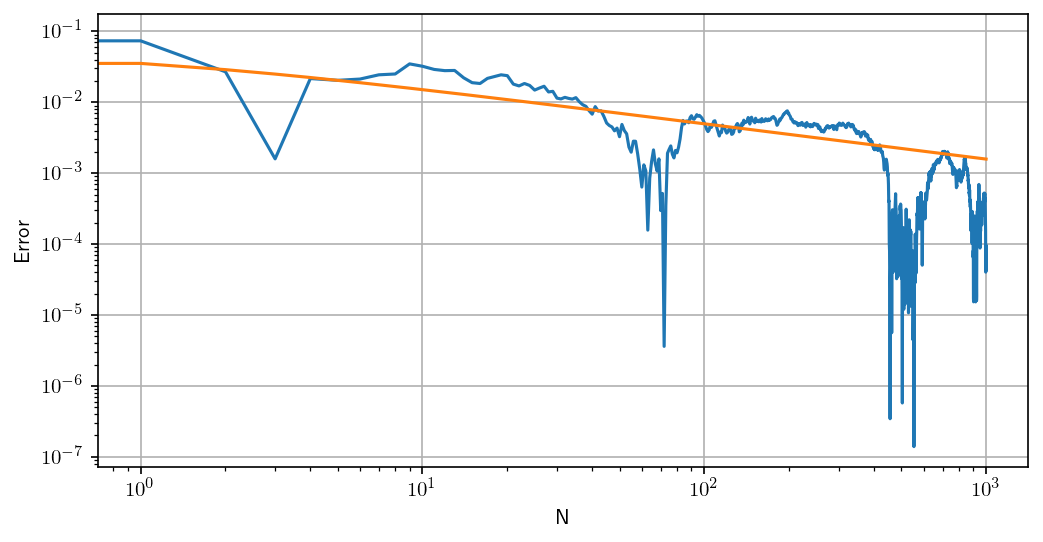

In [16]:
N = 1_000
M = 1_000
x = np.random.random([M, N,2])
r2 = x**2
r2 = np.sum(r2, axis=2)
r2 = np.int32(r2<=1)
results = r2.sum(axis=1)/N
n = np.arange(M)
plt.loglog(n, np.abs(4*np.cumsum(results)/(n+1)-np.pi))
plt.loglog(n, 0.05/np.sqrt(n+1))
plt.xlabel('N')
plt.ylabel('Error');

# Metropolis Hastings algorithm
---------
Allows generation of the _unnormalized_ distribution.

Let f(x) be a desired distibution.

1. choose an initial number $x$
1. choose a test number $x'=x+W$, where $W$ - random number from a symmetic distribution (usually gaussian)
1. if $f(x')>f(x)$ accept $x'$ as a new position
1. if $f(x')<f(x)$ accept $x'$ as the new position only if 
    $$\frac{f(x')}{f(x)}>p$$
    where $p\in [0,1)$ - a random number from a uniform distribution 

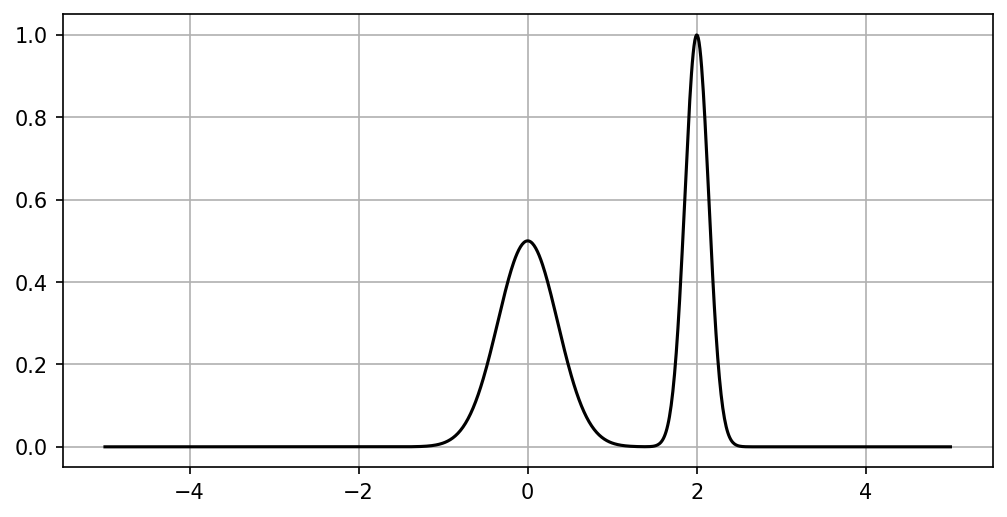

In [54]:
def f(x):
    return 0.5*np.exp(-x**2/0.25)+np.exp(-(x-2)**2/0.04)

x = np.linspace(-5,5, 1000)
plt.plot(x, f(x), 'black')

In [55]:
def metropolis_step(x, y, target_dist, sigma):
    x_test = x + np.random.normal(0, sigma)
    y_test = target_dist(x_test)
    if y_test >  y :
        return (x_test, y_test)
    else:
        p = np.random.random()
        if p < y_test/y:
            return (x_test, y_test)
        else: return (x, y)

NSamples = 1000        
x = np.zeros(Nsamples)
x[0] = 0.5
y = f(x[0])
for n in range(x.size-1):
    x[n+1], y = metropolis_step(x[n], y, f, 0.8)

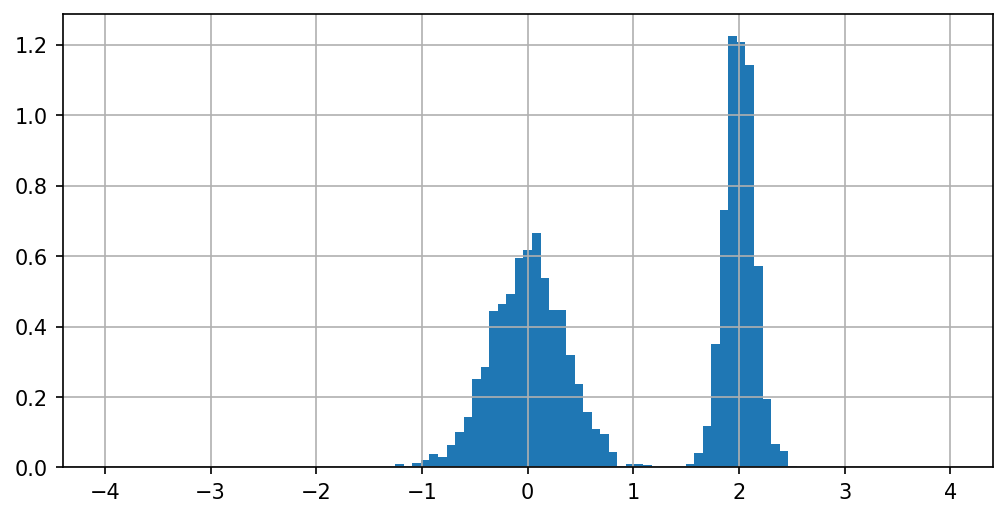

In [56]:
plt.hist(x, bins=np.linspace(-4, 4, 100), density='True', label='generated dist.')
plt.show()

It is useful to calculate averages such as 

$$\frac{\int x^2f(x)\,dx}{\int f(x)dx}$$

In [9]:
print("{:.6f} ± {:.6f}".format(np.mean(x), np.sqrt(np.var(x))))

0.840924 ± 1.025631


In [10]:
def F(x, y):
    return np.exp(-((x-1)**2+(y+0.5)**2)/0.25)  + np.exp(-((x+2)-y**2)**2/0.25)*(1-np.tanh(x))*0.5 + \
        np.exp(-((x)**2+(y-2)**2)/0.125)

def show_Metropolis_random_walk(F, walk):
    plt.figure(figsize=(12,8), dpi=80)
    plt.grid(False)
    xlist = np.linspace(-4.0, 4.0, 300)
    ylist = np.linspace(-3.0, 3.0, 300)
    X, Y = np.meshgrid(xlist, ylist)
    Z = F(X,Y)
    levels = np.linspace(0, 1.1, 6)
    plt.contour(X, Y, Z, levels, colors='k')    
    contour_filled = plt.contourf(X, Y, Z, levels, alpha=0.6)
    plt.plot(walk[:, 0], walk[:, 1], 'r', linewidth=1)
    plt.xlabel('x')
    plt.ylabel('y')
   

In [11]:
def metropolis_step_2d(pos, f, target_dist, sigma):
    pos_test = pos + np.random.normal(0, sigma, 2)    
    f_test = target_dist(*pos_test)
    if f_test >  f :
        return (pos_test, f_test)
    else:
        p = np.random.random()
        if p < f_test/f:
            return (pos_test, f_test)
        else: return (pos, f)

def make_walk(Nsamples):
    walk = np.zeros([Nsamples, 2])
    walk[0, :] = [0, 0]
    f = F(*walk[0])
    for n in range(Nsamples-1):
        walk[n+1,:], f  = metropolis_step_2d(walk[n], f, F, 0.8)

    show_Metropolis_random_walk(F, walk)   

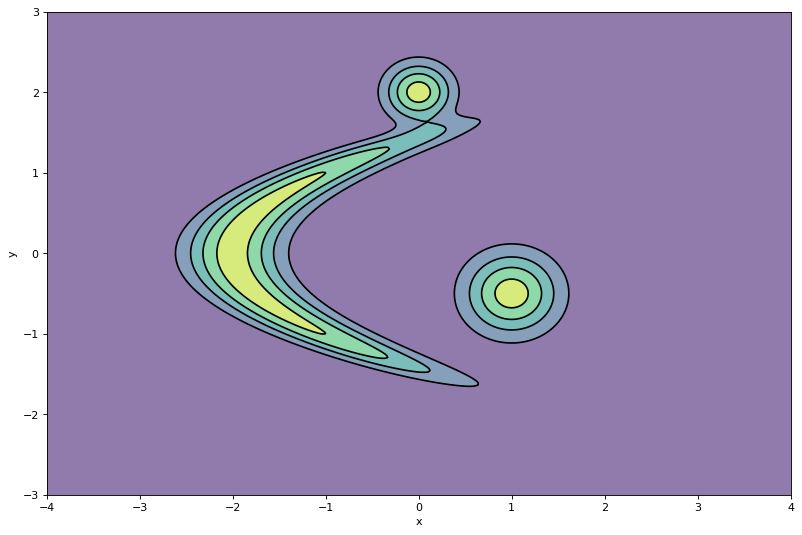

In [12]:
make_walk(1)

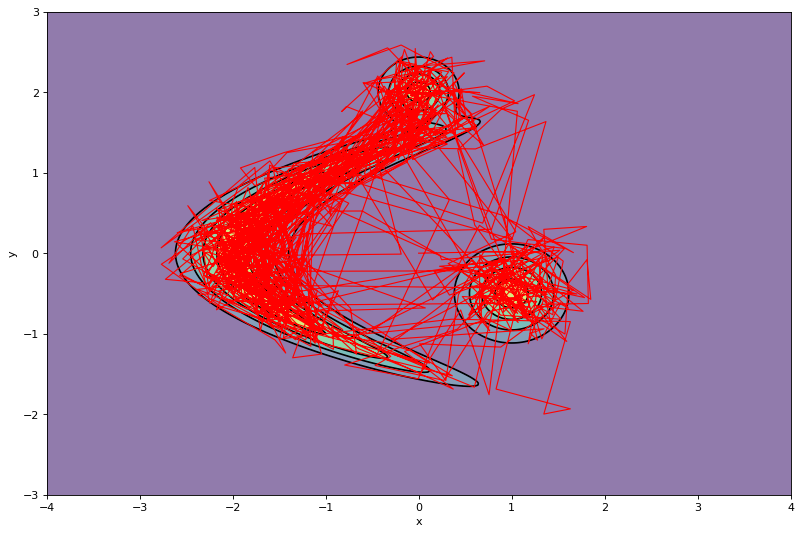

In [13]:
make_walk(3000)

Metropolis Hastings algorithm is particularly useful in statistical and quantum path integral formulation<br>

$${\displaystyle \langle F\rangle ={\frac {\int {\mathcal {D}}[\phi ]F(\phi )e^{{\frac {i}{\hbar }}S[\phi ]}}{\int {\mathcal {D}}[\phi ]e^{{\frac {i}{\hbar }}S[\phi ]}}}}$$

or after Wick rotation $t\to it$:

$${\displaystyle \langle F\rangle ={\frac{1}{Z} {\int {\mathcal {D}}[\phi ]F(\phi )e^{-{\frac {S_E[\phi]}{\hbar }}}}{}}}$$

## Filling gaps - "brownian bridge"

In [14]:
from scipy.stats import norm
N = 1000
def brownian_motion(σ=2, T=10, N=1000):
    t = np.linspace(0, T, N)
    dt = t[1]-t[0]
    n1, n2 = 300, 500
    r = norm.rvs(size=t.shape, scale=σ**2*dt)
    x = np.cumsum(r)  # used cumulative sum instead of loop
    x[n1:n2] = None
    plt.plot(t, x)
    plt.xlabel('$t$', fontsize=16)
    plt.ylabel('$x$',  fontsize=16)
    plt.show()
    return x, n1, n2

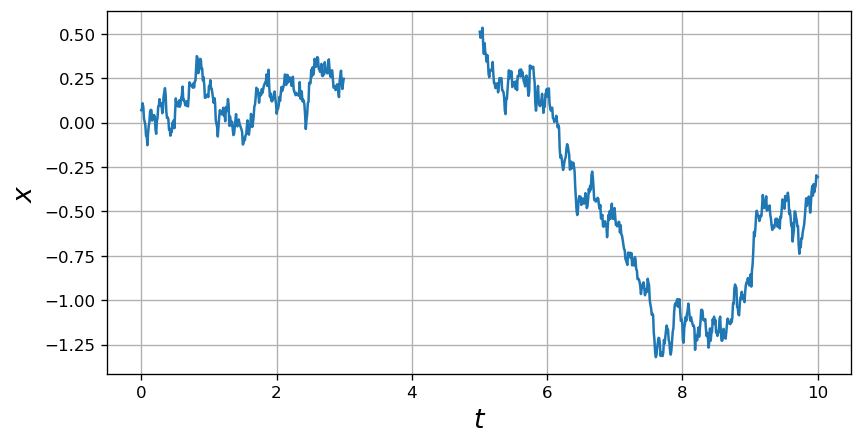

In [15]:
x, n1, n2 = brownian_motion(σ=2, T=10, N=1000)
y = np.concatenate((np.diff(x[0:n1]), np.diff(x[n2:])))
mu, var = np.mean(y), np.var(y)

Missing data problem $X(t_1<t<t_2)$:
- from existing data we can obtain distributions (assuming gaussian for simplicity)
- we need to contruct a random walk from poit $X(t_1)$ to $X(t_2)$ having similar properties as the rest of the data

$$X\left(\frac{t_1+t_2}{2}\right)=\frac{X(t_1)+X(t_2)}{2} + W\left(\sigma_1\sqrt{\frac{t_2-t_1}{2}}\right)$$

where $W(\sigma)$ is a gausian distribution with width $\sigma$. 
Width grows as $\sqrt{\Delta t}$

We repeat the same procedure for data between $\left[t_1,\frac{t_1+t_2}{2} \right]$ and $\left[\frac{t_1+t_2}{2}, t_2 \right]$ scalling the gaussians accordingly

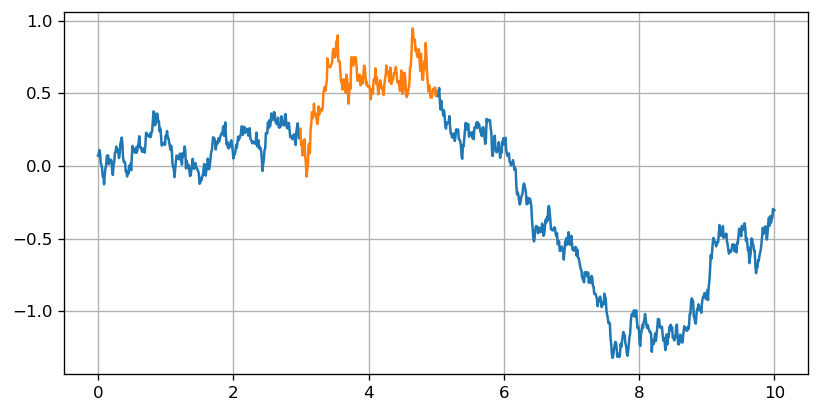

In [16]:
#z = np.zeros(21)
z = np.copy(x[n1-1:n2+1])
def rec(z, a, b):
    c = (a+b)//2
    dn = np.sqrt((b-a)/2)
    z[c] = 0.5*(z[a]+ z[b]) + norm.rvs(scale=np.sqrt(var)*dn) 
    if b-a>2:
        rec(z, a, c)
        rec(z, c, b)
        
rec(z, 0, z.size-1)
#print(z)
t = np.linspace(0, 10, N)
plt.plot(t, x)
plt.plot(t[n1-1:n2+1], z)

Or we can generate a stright line between points $X(t_1)$ and $X(t_2)$<br>
and add random displacements for each intermediate points matching so that 

$$X(t) = \frac{X(t-dt)+X(t+dt)}{2} + W(\sigma_1 \sqrt{dt})$$

This procedure is less cemvergent and may require as many as $N^2$ samples, where $N$ is the number of missing data. 

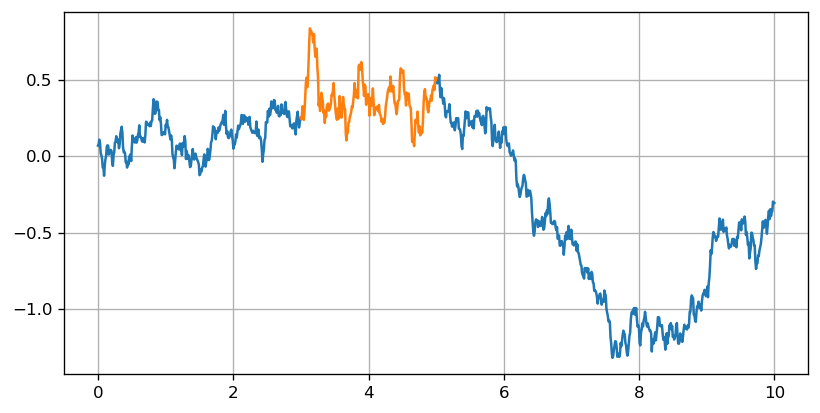

In [17]:
u = np.linspace(z[0], z[-1], z.size)
NN = z.size-2
for n in range(100000):
    k = 1 + int(np.random.random()*NN)
    d = norm.rvs(scale=np.sqrt(var)) 
    u[k] = (u[k-1]+u[k+1] )/2 + d

plt.plot(t, x)
plt.plot(t[n1-1:n2+1], u)

## Stochastic differential equations

Many processes can be modeled with an equation <br>
(physical notation):
$$dy = a(y,t)dt + b(y,t)dW$$

Financial notation

$$dX_t = a(t, X_t)dt + b(t, X_t)dW_t$$

where $dW$ describes a Wienier process (brownian motion) 

The solution can be formally written as 

$$X_t=X_0 + \int_0^ta(s,X_s)\,ds+\int_0^tb(s,X_s)\,dW_s$$


For example Langevin equation (noisy drift)

$$dy = -\frac{(y-\mu)}{\tau} dt + \sigma \sqrt{\frac{2}{\tau}} dW$$

or Black-Scholes model 

$$dS_t=S_t\mu\,dt + S_t\sigma\, dW_t$$

More general:

$$dX_t=a(b-X_t)\,dt +c\sqrt{X_t}\,dW_t$$

Usual integral can be interpreted as a sum

$$\int_0^Ta_t\,dt\approx \sum_{n=0}^N a_{t_n}(t_{n+1}-t_{n})$$

The stochastic one:

$$\int_0^Tb_t\,dW_t\approx \sum_{n=0}^N b_{t_n}(W_{t_{n+1}}-W_{t_{n}})$$

#### Euler-Maruyama scheme

$$X_{n+1}=X_n+a(t_n, X_n)d t +b(t_n, X_n)d W_n$$

The method is convergent if 

$$\lim_{dt \to 0}\operatorname {E}\left(\left|X_T-X^{d t}_T\right|\right)=0.$$

The method is __weakly__ convergent if 

$$\lim_{dt\to 0}\left|\operatorname {E}Q(X_T)-\operatorname {E}Q(X_T^{dt})\right|=0$$

for every polynomial $Q$

The numerical scheme is strongly convergent with order $\gamma$ if

$$\operatorname{E}\left(\left|X_T-X^{d t}_T\right|\right)\leq c_T(dt)^\gamma$$

and weakly convergent with order $\gamma$ if 

$$\left|\operatorname {E}Q(X_T)-\operatorname {E}Q(X_T^{dt})\right|\leq c_T(dt)^\gamma$$

Euler-Maruyama scheme is strongly convergent with order $1/2$ and weakly convergent with order $1$ for suffieciently smooth functions (continuous $a^{(4)}$ and $b^{(4)}$) <br>

Weak convergence is important at specific time<br>
Strong convergence is important for a path as a whole. 


#### Milstein scheme (both orders 1)

$$X_{n+1}=X_n+a(X_n)\delta t+b(X_n)\delta W_n+\frac{1}{2}b'(X_n)b(X_n)\left(\delta W_n^2-\delta t \right)$$

Other methods:
* Stratonovich Heun algorithm
* order 1.0 strong Stochastic Runge-Kutta algorithm SRI2
* the Kloeden and Platen two-step implicit order 1.0 strong algorithm

## Tasks:
1. Implement MC method for calculation $\pi/4$
    -plot error as a function of Nsamples
    - optimize using numpy vectorization (choose all numbers at once etc.)
    - calculate the volume of a unit ball in 100 dimensions (how many calculations quad would use performing integration in all dimensions).
1. Implement Box-Muller method and generate the gaussian distribution
1. Implement rejection method for gaussian or exponential distribution and compare with another method
1. Generate a brownian motion with a drift

5. Generate brownian motion with distribution obtained from the real data
1. Solve the equation
$$dx = -(a + x b^2)(1 - x^2)dt + b(1 - x^2)dW$$
where $a=1.0, b=0.8$ are parameters.<br>
Check convergence order.